
# Random Forest

## Titanic Dataset

In [1]:
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn import tree
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
from boto3 import session

In [3]:
role = get_execution_role()
bucket='sonata-datascience'
data_key = 'data/titanic.csv'
train_df = 's3://{}/{}'.format(bucket, data_key)
train_df = pd.read_csv(train_df)
test_df = 's3://{}/{}'.format(bucket, 'data/titanic_test.csv')
test_df = pd.read_csv(test_df)

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df["Sex"] = train_df["Sex"].apply(lambda sex: 0 if sex == 'male' else 1)

In [7]:
y = targets = labels = train_df["Survived"].values

columns = ["Fare", "Pclass", "Sex", "Age", "SibSp"]
features = train_df[list(columns)].values
features

array([[ 7.25  ,  3.    ,  0.    , 22.    ,  1.    ],
       [71.2833,  1.    ,  1.    , 38.    ,  1.    ],
       [ 7.925 ,  3.    ,  1.    , 26.    ,  0.    ],
       ...,
       [23.45  ,  3.    ,  1.    ,     nan,  1.    ],
       [30.    ,  1.    ,  0.    , 26.    ,  0.    ],
       [ 7.75  ,  3.    ,  0.    , 32.    ,  0.    ]])

In [8]:
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB


In [10]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(features)
X

array([[ 7.25      ,  3.        ,  0.        , 22.        ,  1.        ],
       [71.2833    ,  1.        ,  1.        , 38.        ,  1.        ],
       [ 7.925     ,  3.        ,  1.        , 26.        ,  0.        ],
       ...,
       [23.45      ,  3.        ,  1.        , 29.69911765,  1.        ],
       [30.        ,  1.        ,  0.        , 26.        ,  0.        ],
       [ 7.75      ,  3.        ,  0.        , 32.        ,  0.        ]])

In [12]:
my_tree_one = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
my_tree_one = my_tree_one.fit(X, y)

In [13]:
#The feature_importances_ attribute make it simple to interpret the significance of the predictors you include
print(my_tree_one.feature_importances_) 
print(my_tree_one.score(X, y))

[0.12330431 0.18665493 0.5670424  0.09423074 0.02876762]
0.8226711560044894


In [15]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
test_df["Sex"] = test_df["Sex"].apply(lambda sex: 0 if sex == 'male' else 1)
#features_test = train_df[list(columns)].values
features_test = test_df[list(columns)].values
imp_test = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test = imp_test.fit_transform(features_test)
X_test

array([[ 7.8292    ,  3.        ,  0.        , 34.5       ,  0.        ],
       [ 7.        ,  3.        ,  1.        , 47.        ,  1.        ],
       [ 9.6875    ,  2.        ,  0.        , 62.        ,  0.        ],
       ...,
       [ 7.25      ,  3.        ,  0.        , 38.5       ,  0.        ],
       [ 8.05      ,  3.        ,  0.        , 30.27259036,  0.        ],
       [22.3583    ,  3.        ,  0.        , 30.27259036,  1.        ]])

In [17]:
pred = my_tree_one.predict(X_test)
pred


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [18]:
#Print Confusion matrix 
pred = my_tree_one.predict(X)
df_confusion = metrics.confusion_matrix(y, pred)
df_confusion

array([[490,  59],
       [ 99, 243]])

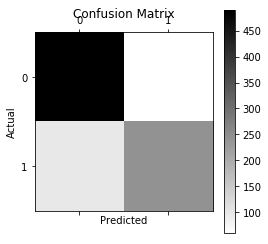

In [53]:

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(df_confusion)

#### What happen when we change the tree depth?

In [19]:
#Setting "max_depth" to 10 and "min_samples_split" to 5 : my_tree_two
max_depth = 10
min_samples_split = 5
my_tree_two = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 1)
my_tree_two = my_tree_two.fit(X, y)

#Print the score of the new decison tree
print(my_tree_two.score(X, y))

0.9012345679012346


In [20]:
pred = my_tree_two.predict(X)

In [21]:
df_confusion = metrics.confusion_matrix(y, pred)
df_confusion

array([[533,  16],
       [ 72, 270]])

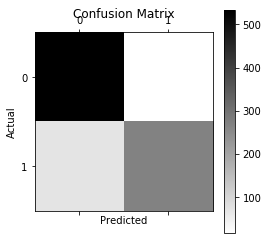

In [22]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(df_confusion)

In [23]:
# Add new feature and then train the model

train_df["family_size"] = train_df.SibSp + train_df.Parch + 1


# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Building and fitting my_forest
forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1)
my_forest = forest.fit(X, y)

# Print the score of the fitted random forest
print(my_forest.score(X, y))


0.9393939393939394


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [24]:

pred = my_forest.predict(X)

In [25]:
df_confusion = metrics.confusion_matrix(y, pred)
df_confusion

array([[538,  11],
       [ 43, 299]])

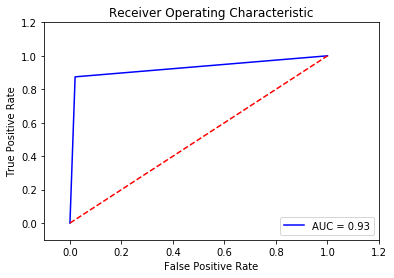

In [26]:
fpr, tpr, _ = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()